/home/darkcover/Documentos/Out/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Época 1/25 - Precisão: 1.9994, Acurácia Direcional: 3.9621, Acurácia Direcional Ponderada: 5.9615
Época 2/25 - Precisão: 2.0150, Acurácia Direcional: 3.9609, Acurácia Direcional Ponderada: 5.9759
Época 3/25 - Precisão: 2.0233, Acurácia Direcional: 3.9611, Acurácia Direcional Ponderada: 5.9844
Época 4/25 - Precisão: 2.0295, Acurácia Direcional: 3.9611, Acurácia Direcional Ponderada: 5.9905
Época 5/25 - Precisão: 1.9912, Acurácia Direcional: 3.9622, Acurácia Direcional Ponderada: 5.9534
Época 6/25 - Precisão: 1.9535, Acurácia Direcional: 3.9625, Acurácia Direcional Ponderada: 5.9160
Época 7/25 - Precisão: 2.0324, Acurácia Direcional: 3.9607, Acurácia Direcional Ponderada: 5.9931
Época 8/25 - Precisão: 2.0586, Acurácia Direcional: 3.9618, Acurácia Direcional Ponderada: 6.0203
Época 9/25 - Precisão: 2.0343, Acurácia Direcional: 3.9627, Acurácia Direcional Ponderada: 5.9970
Época 10/25 - Precisão: 2.0187, Acurácia Direcional: 3.9617, Acurácia Direcional Ponderada: 5.9803
Época 11/25 - Preci

2024-06-09 14:12:03.515454: W tensorflow/core/data/root_dataset.cc:350] Optimization loop failed: CANCELLED: Operation was cancelled


Época 24/25 - Precisão: 1.9445, Acurácia Direcional: 3.9613, Acurácia Direcional Ponderada: 5.9058
Época 25/25 - Precisão: 2.1103, Acurácia Direcional: 3.9573, Acurácia Direcional Ponderada: 6.0676


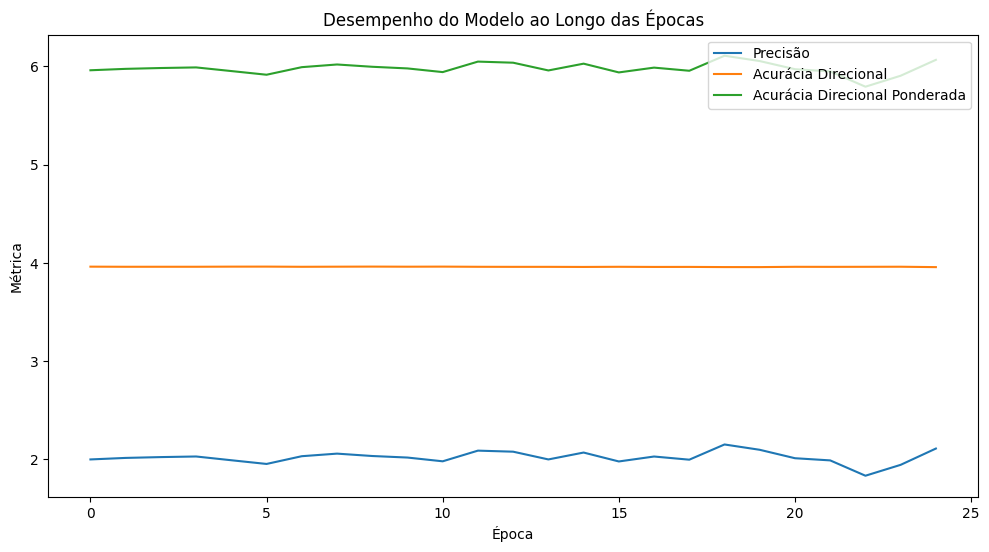

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, n_states, n_actions, learning_rate=0.001, gamma=0.99, epsilon=1.0, buffer_size=10000):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=buffer_size)

        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, input_dim=self.n_states, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(self.n_actions, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.n_actions)
        q_values = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state.reshape(1, -1), batch_size=1, verbose=0)[0]))
            target_f = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def calculate_reward(action, acerto):
    if action == 1:
        if acerto == 1:
            return 10
        elif acerto == 2:
            return -5
    return 0

def normalize_data(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def main():
    data = pd.read_csv('/home/darkcover/Documentos/Out/dados/data_final.csv')
    features = data[['odd_entrada', 'media5', 'media10', 'media20', 'media40', 'media80', 'media160', 'media320', 'media640', 'level', 'contagem']].values
    rewards = data['apostar'].values
    features = normalize_data(features)

    X_train, X_test, y_train, y_test = train_test_split(features, rewards, test_size=0.2, random_state=42)

    n_epochs = 25
    batch_size = 128

    n_states = X_train.shape[1]
    n_actions = 2
    dqn_agent = DQNAgent(n_states, n_actions)

    epoch_accuracies = []
    epoch_directional_accuracies = []
    epoch_weighted_directional_accuracies = []

    for epoch in range(n_epochs):
        correct_predictions = 0
        overestimations = 0
        weighted_correct_predictions = 0
        weighted_overestimations = 0

        for i in range(len(X_train) - 1):
            state = X_train[i]
            action = dqn_agent.get_action(state)
            true_action = y_train[i]
            acerto = state[-3]
            reward = calculate_reward(action, acerto)
            next_state = X_train[i + 1]
            done = (i == len(X_train) - 2)

            dqn_agent.remember(state, action, reward, next_state, done)
            if done:
                dqn_agent.replay(batch_size)

            if action == true_action:
                correct_predictions += 1
                weighted_correct_predictions += 2
            elif action > true_action:
                overestimations += 1
                weighted_overestimations += 1

        epoch_accuracy = correct_predictions / len(X_test)
        epoch_directional_accuracy = (correct_predictions + overestimations) / len(X_test)
        epoch_weighted_directional_accuracy = (weighted_correct_predictions + weighted_overestimations) / len(X_test)

        epoch_accuracies.append(epoch_accuracy)
        epoch_directional_accuracies.append(epoch_directional_accuracy)
        epoch_weighted_directional_accuracies.append(epoch_weighted_directional_accuracy)

        print(f'Época {epoch + 1}/{n_epochs} - Precisão: {epoch_accuracy:.4f}, Acurácia Direcional: {epoch_directional_accuracy:.4f}, Acurácia Direcional Ponderada: {epoch_weighted_directional_accuracy:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(epoch_accuracies, label='Precisão')
    plt.plot(epoch_directional_accuracies, label='Acurácia Direcional')
    plt.plot(epoch_weighted_directional_accuracies, label='Acurácia Direcional Ponderada')
    plt.xlabel('Época')
    plt.ylabel('Métrica')
    plt.legend()
    plt.title('Desempenho do Modelo ao Longo das Épocas')
    plt.show()

if __name__ == "__main__":
    main()


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, n_states, n_actions, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, buffer_size=10000):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=buffer_size)
        self.model = self.build_model()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber())

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.n_states,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(self.n_actions, activation='linear')
        ])
        return model

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            q_values = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
            return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1), batch_size=1, verbose=0))
            target_f = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def calculate_reward(action, acerto):
    reward = 0
    if action == 1:  # Apostou
        if acerto == 1:
            reward = 1  # Recompensa por apostar corretamente
        elif acerto == 2:
            reward = -1  # Penalidade por apostar incorretamente
    return reward

def normalize_data(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def main():
    # Carregar os dados
    data = pd.read_csv('/home/darkcover/Documentos/Out/dados/data_final.csv')

    # Selecionar as features e a variável de saída
    features = data[['odd_entrada', 'media5', 'media10', 'media20', 'media40', 'media80', 'media160', 'media320', 'media640']].values
    actions = data['apostar'].values  # Variável de saída: se deve apostar ou não
    acertos = data[['acerto', 'level', 'contagem']].values  # Variável de saída para calcular a recompensa

    features = normalize_data(features)

    # Adicionar level e contagem às features
    features = np.hstack((features, acertos[:, 1:]))

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test, acerto_train, acerto_test = train_test_split(features, actions, acertos, test_size=0.2, random_state=42)

    # Parâmetros de treinamento
    n_epochs = 5
    batch_size = 264

    # Crie o agente DQN
    n_states = X_train.shape[1]
    n_actions = 2  # Ações possíveis: apostar ou não apostar
    dqn_agent = DQNAgent(n_states, n_actions, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01, buffer_size=10000)

    epoch_accuracies = []
    epoch_directional_accuracies = []
    epoch_weighted_directional_accuracies = []

    # Treinamento do agente
    for epoch in range(n_epochs):
        correct_predictions = 0
        overestimations = 0
        weighted_correct_predictions = 0
        weighted_overestimations = 0

        for i in range(len(X_train) - 1):
            state = X_train[i, :]
            action = dqn_agent.get_action(state)
            true_action = y_train[i]
            acerto = acerto_train[i][0]
            reward = calculate_reward(action, acerto)
            next_state = X_train[i + 1, :]
            done = (i == len(X_train) - 2)

            dqn_agent.remember(state, action, reward, next_state, done)

            if done:
                dqn_agent.replay(batch_size)
                dqn_agent.update_epsilon()

            if action == true_action:
                correct_predictions += 1
                weighted_correct_predictions += 2  # Peso maior para acertos exatos
            elif action > true_action:
                overestimations += 1
                weighted_overestimations += 1  # Peso menor para erros

        epoch_accuracy = correct_predictions / len(X_test)
        epoch_directional_accuracy = (correct_predictions + overestimations) / len(X_test)
        epoch_weighted_directional_accuracy = (weighted_correct_predictions + weighted_overestimations) / len(X_test)

        epoch_accuracies.append(epoch_accuracy)
        epoch_directional_accuracies.append(epoch_directional_accuracy)
        epoch_weighted_directional_accuracies.append(epoch_weighted_directional_accuracy)

        print(f'Época {epoch + 1}/{n_epochs} - Precisão: {epoch_accuracy:.4f}, Acurácia Direcional: {epoch_directional_accuracy:.4f}, Acurácia Direcional Ponderada: {epoch_weighted_directional_accuracy:.4f}')

    # Teste o agente
    correct_predictions = 0
    overestimations = 0
    weighted_correct_predictions = 0
    weighted_overestimations = 0

    predicted_actions = []

    for i in range(len(X_test)):
        state = X_test[i, :]
        action = dqn_agent.get_action(state)
        true_action = y_test[i]

        predicted_actions.append(action)

        if action == true_action:
            correct_predictions += 1
            weighted_correct_predictions += 2
        elif action > true_action:
            overestimations += 1
            weighted_overestimations += 1

    accuracy = correct_predictions / len(X_test)
    directional_accuracy = (correct_predictions + overestimations) / len(X_test)
    weighted_directional_accuracy = (weighted_correct_predictions + weighted_overestimations) / len(X_test)

    print("Precisão:", accuracy)
    print("Acurácia Direcional:", directional_accuracy)
    print("Acurácia Direcional Ponderada:", weighted_directional_accuracy)

    plt.figure(figsize=(12, 6))
    plt.plot(epoch_accuracies, label='Precisão')
    plt.plot(epoch_directional_accuracies, label='Acurácia Direcional')
    plt.plot(epoch_weighted_directional_accuracies, label='Acurácia Direcional Ponderada')
    plt.xlabel('Época')
    plt.ylabel('Métrica')
    plt.title('Desempenho do Modelo ao Longo das Épocas')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    metrics = [accuracy, directional_accuracy, weighted_directional_accuracy]
    metric_labels = ['Precisão', 'Acurácia Direcional', 'Acurácia Direcional Ponderada']
    colors = ['blue', 'orange', 'green']
    plt.bar(metric_labels, metrics, color=colors)
    plt.xlabel('Métricas')
    plt.ylabel('Valor')
    plt.title('Métricas de Desempenho no Conjunto de Teste')
    plt.ylim(0, 1)
    plt.show()

    dqn_agent.model.save('AgenteAposta.h5')
    data_save = pd.DataFrame({'epoch_accuracies': epoch_accuracies,
                              'epoch_directional_accuracies': epoch_directional_accuracies,
                              'epoch_weighted_directional_accuracies': epoch_weighted_directional_accuracies})
    data_save.to_csv('/home/darkcover/Documentos/Out/dados/metricas_aposta.csv', index=False)

if __name__ == '__main__':
    main()


2024-06-18 13:14:21.980749: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 13:14:22.081447: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 13:14:22.572251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 13:14:26.253084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
from datetime import timedelta, datetime, time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.stats import entropy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")


2024-06-18 12:25:59.631988: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 12:25:59.737802: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 12:26:00.305591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 12:26:04.285181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Carregar os dados
data = pd.read_csv('/home/darkcover/Documentos/Out/dados/data_final.csv')

    # Selecionar as features e a variável de saída
features = data[['odd_entrada', 'media5', 'media10', 'media20', 'media40', 'media80', 'media160', 'media320', 'media640']].values
actions = data['apostar'].values  # Variável de saída: se deve apostar ou não
    

In [3]:
# Separar recursos (X) e rótulos (y)
X1 = features
y1 = actions

# Normalizar os recursos (importante para redes neurais)
scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

# Divida seus dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Crie uma instância do GradientBoostingClassifier
clf = GradientBoostingClassifier()

# Execute a pesquisa de grade no conjunto de treinamento
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Calcular o F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score do modelo: {f1}')

Acurácia do modelo: 1.0
F1-Score do modelo: 1.0


In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar recursos (X) e rótulos (y)
X1 = features
y1 = actions

# Normalizar os recursos (importante para redes neurais)
scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)


# Divida seus dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(12, activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=250, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia nos dados de teste: {test_accuracy}')


# Fazer previsões
predictions = model.predict(X_test)

# Arredondar as previsões para obter rótulos de classe
predicted_labels = np.argmax(predictions, axis=1)

# Calcular o F1-Score
f1 = f1_score(y_test, predicted_labels, average='weighted')

print(f'F1-Score do modelo: {f1}')


Epoch 1/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9648 - loss: 0.1858 - val_accuracy: 0.9911 - val_loss: 0.0270
Epoch 2/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9879 - loss: 0.0323 - val_accuracy: 0.9912 - val_loss: 0.0228
Epoch 3/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9912 - loss: 0.0227 - val_accuracy: 0.9899 - val_loss: 0.0260
Epoch 4/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9918 - loss: 0.0221 - val_accuracy: 0.9927 - val_loss: 0.0220
Epoch 5/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9931 - loss: 0.0195 - val_accuracy: 0.9946 - val_loss: 0.0171
Epoch 6/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9937 - loss: 0.0164 - val_accuracy: 0.9934 - val_loss: 0.0227
Epoch 7/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9933 - loss: 0.0166 - val_accuracy: 0.9957 - val_loss: 0.0198
Epoch 8/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9935 - 

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

# Separar recursos (X) e rótulos (y)
X1 = features
y1 = actions

# Normalizar os recursos (importante para redes neurais)
scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

# Divida seus dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(24, activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

# Experimente diferentes funções de ativação, taxa de aprendizado e otimizador
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Aumente o número de épocas
model.fit(X_train, y_train, epochs=250, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia nos dados de teste: {test_accuracy}')

# Fazer previsões
predictions = model.predict(X_test)

# Arredondar as previsões para obter rótulos de classe
predicted_labels = np.argmax(predictions, axis=1)

# Calcular o F1-Score
f1 = f1_score(y_test, predicted_labels, average='weighted')

print(f'F1-Score do modelo: {f1}')


Epoch 1/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9769 - loss: 0.1501 - val_accuracy: 0.9918 - val_loss: 0.0220
Epoch 2/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9898 - loss: 0.0261 - val_accuracy: 0.9917 - val_loss: 0.0221
Epoch 3/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9920 - loss: 0.0212 - val_accuracy: 0.9929 - val_loss: 0.0209
Epoch 4/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9927 - loss: 0.0188 - val_accuracy: 0.9945 - val_loss: 0.0194
Epoch 5/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9938 - loss: 0.0158 - val_accuracy: 0.9944 - val_loss: 0.0215
Epoch 6/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9936 - loss: 0.0162 - val_accuracy: 0.9921 - val_loss: 0.0345
Epoch 7/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9937 - loss: 0.0150 - val_accuracy: 0.9949 - val_loss: 0.0276
Epoch 8/250
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9946 -

In [7]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np
from keras.optimizers import Nadam

# Separar recursos (X) e rótulos (y)
X1 = features
y1 = actions

# Normalizar os recursos (importante para redes neurais)
scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

# Divida seus dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

model = keras.Sequential([
    keras.layers.Dense(160, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(320, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(480, activation='relu'),
    keras.layers.Dense(640, activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

# Experimente diferentes funções de ativação, taxa de aprendizado e otimizador
model.compile(optimizer=nadam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Aumente o número de épocas
model.fit(X_train, y_train, epochs=250, batch_size=160, validation_split=0.001, callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia nos dados de teste: {test_accuracy}')

# Fazer previsões
predictions = model.predict(X_test)

# Arredondar as previsões para obter rótulos de classe
predicted_labels = np.argmax(predictions, axis=1)

# Calcular o F1-Score
f1 = f1_score(y_test, predicted_labels, average='weighted')

print(f'F1-Score do modelo: {f1}')


Epoch 1/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - accuracy: 0.9748 - loss: 0.2187 - val_accuracy: 0.9937 - val_loss: 0.0136
Epoch 2/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.9897 - loss: 0.0273 - val_accuracy: 0.9937 - val_loss: 0.0122
Epoch 3/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9915 - loss: 0.0218 - val_accuracy: 0.9937 - val_loss: 0.0120
Epoch 4/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.9925 - loss: 0.0190 - val_accuracy: 0.9937 - val_loss: 0.0119
Epoch 5/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9933 - loss: 0.0175 - val_accuracy: 0.9937 - val_loss: 0.0077
Epoch 6/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9939 - loss: 0.0163 - val_accuracy: 0.9937 - val_loss: 0.0158
Epoch 7/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9940 - loss: 0.0223 - val_accuracy: 0.9937 - val_loss: 0.0075
Epoch 8/250
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9943 - loss: 0

KeyboardInterrupt: 